In [38]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import tqdm

In [39]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

In [40]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO,self).__init__()
        
        self.fc1=nn.Linear(4,256)
        self.fc_pi=nn.Linear(256,2)
        self.fc_v=nn.Linear(256,1)
        
        self.optimizer=optim.Adam(self.parameters(),lr=learning_rate)
        self.data=list()
        
    def pi(self,x,soft_dim=0):
        
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc_pi(x)
        prob=F.softmax(x,dim=soft_dim)
        return prob
    
    def v(self,x):
        
        x=self.fc1(x)
        x=F.relu(x)
        v=self.fc_v(x)
        return v
    
    def put_data(self,transition):
        self.data.append(transition)
        
    def make_batch(self):
        
        s_lst,a_lst,r_lst,s_prime_lst,prob_lst,done_lst=[],[],[],[],[],[]
        
        for transition in self.data:
            s,a,r,s_prime,prob,done=transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_lst.append([prob])
            
            done_mask=0 if done else 1
            done_lst.append([done_mask])
            
        self.data=list()
        
        return torch.tensor(s_lst,dtype=torch.float),torch.tensor(a_lst),\
    torch.tensor(r_lst,dtype=torch.float),torch.tensor(s_prime_lst,dtype=torch.float),\
    torch.tensor(prob_lst,dtype=torch.float),torch.tensor(done_lst,dtype=torch.float)
    
    def train_net(self):
        
        s,a,r,s_prime,old_prob,done=self.make_batch()
        
        for i in range(5): #Data Epoch Training
            td_target=r+gamma*self.v(s_prime)*done
            delta=td_target-self.v(s)
            delta=delta.detach()
            
            #Generalized Advantage Estimation
            advantage=0
            advantage_lst=list()
            delta=delta.numpy()
            
            for delta_t in delta[::-1]:
                advantage=gamma*lmbda*advantage+delta_t
                advantage_lst.append(advantage)
                
            advantage_lst.reverse()
            advantage=torch.tensor(advantage_lst,dtype=torch.float)
            
            prob=self.pi(s,soft_dim=1)
            prob_a=prob.gather(1,a)
            
            ratio=torch.exp(torch.log(prob_a)-torch.log(old_prob))
            
            surr1=ratio*advantage
            surr2=torch.clamp(ratio,1-eps_clip,1+eps_clip)*advantage
            
            loss=-torch.min(surr1,surr2)+F.smooth_l1_loss(self.v(s),td_target.detach())
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        

In [41]:
reward_list1=list()
env=gym.make('CartPole-v1')
model=PPO()
score=0.

In [42]:
for n_epi in tqdm.trange(1000):
    s=env.reset()
    done=False
    t=0
    while not done:
        prob=model.pi(torch.from_numpy(s).float())
        m=Categorical(prob)
        a=m.sample().item()
        s_prime,r,done,_=env.step(a)
        model.put_data((s,a,r/100.,s_prime,prob[a],done))
        s=s_prime
        t+=1
        score+=r
        if done:
            break
    model.train_net()
    reward_list1.append(t)
    score=0
env.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.77it/s]


In [43]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


learning_rate = 0.0002
gamma         = 0.98
n_rollout     = 10

class ActorCritic(nn.Module):
    
    def __init__(self):
        super(ActorCritic,self).__init__()
        self.data=list()
        
        self.fc1=nn.Linear(4,256)
        self.fc_pi=nn.Linear(256,2)
        self.fc_v=nn.Linear(256,1)
        
        self.optimizer=optim.Adam(self.parameters(),lr=learning_rate)
        
    def pi(self,x,soft_dim=0):
        
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc_pi(x)
        prob=F.softmax(x,dim=soft_dim)
        return prob
    
    def v(self,x):
        x=self.fc1(x)
        x=F.relu(x)
        v=self.fc_v(x)
        return v
    
    def put_data(self,transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst,a_lst,r_lst,s_prime_lst,done_lst=[],[],[],[],[]
        
        for transition in self.data:
            
            s,a,r,s_prime,done=transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.])
            s_prime_lst.append(s_prime)
            
            done_mask=0 if done else 1
            
            done_lst.append([done_mask])
            
        self.data=[]
        return torch.tensor(s_lst,dtype=torch.float),torch.tensor(a_lst),torch.tensor(r_lst,dtype=torch.float),\
    torch.tensor(s_prime_lst,dtype=torch.float),torch.tensor(done_lst,dtype=torch.float)
    
    
    def train_net(self):
        s,a,r,s_prime,done=self.make_batch()
        
        td_target=r+gamma*self.v(s_prime)*done
        advantage=td_target-self.v(s)

        
        prob=self.pi(s,soft_dim=1)
        prob_a=prob.gather(1,a)
        
        loss=-torch.log(prob_a)*advantage.detach()+F.smooth_l1_loss(self.v(s),td_target.detach())
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

In [44]:
reward_list2=list()
model=ActorCritic()
env=gym.make('CartPole-v1')
score=0
for n_epi in tqdm.trange(1000):
    done=False
    s=env.reset()
    t=0
    while not done:
            
            prob=model.pi(torch.from_numpy(s).float())
            m=Categorical(prob)
            a=m.sample().item()
            s_prime,r,done,_=env.step(a)

            model.put_data((s,a,r,s_prime,done))
            s=s_prime
            t+=1
            score+=r
            if done:
                break
    reward_list2.append(t)
    model.train_net()
    score=0
    


env.close()
        

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.75it/s]


In [45]:
import matplotlib.pyplot as plt        

In [46]:
def mean_list(reward_list1,reward_lsit2,t=10):

    r1=list()
    r2=list()

    r1_mean=list()
    r2_mean=list()

    for a,b in zip(reward_list1,reward_list2):
        r1.append(a)
        r2.append(b)

        if len(r1)==t and len(r2)==t:
            r1_mean.append(sum(r1)/20)
            r2_mean.append(sum(r2)/20)
            r1=list()
            r2=list()
            
    return r1_mean,r2_mean

def visual(r1,r2):
    
    plt.title("PPO vs Naive Actor Critic")
    plt.ylabel('Duration')
    plt.plot(r1)
    plt.plot(r2)
    plt.legend(['PPO',"Naive"])
    plt.show()

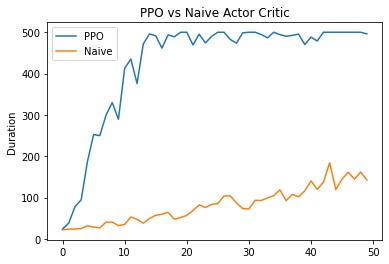

In [48]:
r1,r2=mean_list(reward_list1,reward_list2,20)

visual(r1,r2)